# DAS Code

In [201]:
import numpy as np
import pandas as pd
import pickle
import random
import geopy.distance
import datetime 
import multiprocessing

In [98]:
# Load in Airbnbs and Museum data
Abnb = pd.read_csv('AbnbFiltered',index_col = 0)
Museum = pd.read_csv('Museum',index_col = 0)

In [6]:
Abnb.head()

,id,latitude,longitude,price
0,9554,51.587767,-0.105666,35.0
1,11076,51.515645,-0.314508,70.0
2,90663,51.507800,-0.122597,231.0
3,13913,51.568017,-0.111208,55.0
4,90681,51.447624,-0.057157,51.0


In [7]:
Museum.head()

,latitude,longitude
2 Willow Road,51.557200,-0.169169
7 Hammersmith Terrace,51.489823,-0.242515
18 Stafford Terrace,51.500472,-0.196944
575 Wandsworth Road,51.469671,-0.140646
All Hallows-by-the-Tower,51.509400,-0.079400


## Profile 3 Distance Calculations

In [8]:
######################################
######## Profile 3 approaches ########
######################################

# Use a random number generator to pick two sets or coords for musuem and Airbnb locations

AbnbTestCoords = Abnb.iloc[random.randint(1,len(Abnb)),:]
MuseumTestCoords = Museum.iloc[random.randint(1,len(Museum)),:]

# assign to a tuple 
AbnbTestCoordsTuple = (AbnbTestCoords.iloc[1],AbnbTestCoords.iloc[2])
MuseumTestCoordsTuple = (MuseumTestCoords.iloc[0],MuseumTestCoords.iloc[1])

In [9]:
## Geodesic
def Geodesic(coords1,coords2):
    return geopy.distance.geodesic(coords1,coords2).km

In [10]:
%timeit  -n 100 Geodesic(AbnbTestCoordsTuple,MuseumTestCoordsTuple)

492 µs ± 64.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
distanceGeoD = Geodesic(AbnbTestCoordsTuple,MuseumTestCoordsTuple)

In [12]:
## Great circle distance
def GreatCircleDistance(coords1,coords2):
    return geopy.distance.great_circle(coords1,coords2).km

In [13]:
%timeit  -n 100 GreatCircleDistance(AbnbTestCoordsTuple,MuseumTestCoordsTuple)

34 µs ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
distanceGCD = GreatCircleDistance(AbnbTestCoordsTuple,MuseumTestCoordsTuple)

In [15]:
## Vincenty
def Vincenty(coords1,coords2):
    return geopy.distance.vincenty(coords1,coords2).km

In [16]:
%timeit  -n 100 Vincenty(AbnbTestCoordsTuple,MuseumTestCoordsTuple)

88 µs ± 43.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
distanceVincenty = Vincenty(AbnbTestCoordsTuple,MuseumTestCoordsTuple)

In [18]:
print(distanceGeoD,distanceGCD,distanceVincenty)

3.259536713369614 3.2494782610337207 3.2595367063771805


## Pure Python Approach

In [276]:
######################################
############ Pure Python #############
######################################

# Create a function that will calculate the min distance in km 
# Not all museums popular, could count number of museums within x distance

def minDist(df1,df2):
    ''' Take two dataframes of coordinates and calculate the min distance 
    from one df1 coords to all df2 coords. Return a dictionary with the rows id and minimum distance'''
    start=datetime.datetime.now()
    min_distances={}
    for i in range(len(df1)):
        Airbnb_coords = (df1['latitude'][i],df1['longitude'][i])
        distances = []
        for j in range(len(df2)):
            museum_coords = (df2['latitude'][j],df2['longitude'][j])
            distances.append(geopy.distance.vincenty(Airbnb_coords, museum_coords).km)
        min_distances.update({df1['id'][i]:min(distances)})
    print("{} - finish in {}".format(datetime.datetime.now(), datetime.datetime.now()-start))
    return min_distances

In [294]:
# an attempt to compile the single threaded approach

from numba import jit , prange
# just in time
@jit(parallel=True)
def minDist_2(df1,df2):
    ''' Take two dataframes of coordinates and calculate the min distance 
    from one df1 coords to all df2 coords. Return a dictionary with the rows id and minimum distance'''
    start=datetime.datetime.now()
    min_distances={}
    for i in prange(len(df1)):
        Airbnb_coords = (df1['latitude'][i],df1['longitude'][i])
        distances = []
        for j in prange(len(df2)):
            museum_coords = (df2['latitude'][j],df2['longitude'][j])
            distances.append(geopy.distance.vincenty(Airbnb_coords, museum_coords).km)
        min_distances.update({df1['id'][i]:min(distances)})
    print("{} - finish in {}".format(datetime.datetime.now(), datetime.datetime.now()-start))
    return min_distances

In [295]:
# From playing around with prange no significant time improvement was found
MinTest = minDist_2(Abnb.iloc[:100,:],Museum)

2019-01-03 12:57:09.572719 - finish in 0:00:03.067681


In [317]:
# Try on a subset to see if function works 
MinTest = minDist(Abnb.iloc[:100,:],Museum)

2019-01-03 13:20:31.763962 - finish in 0:00:02.812593


In [78]:
# Once happy with the function working, compute for all
SingleResults = minDist(Abnb,Museum)

2019-01-02 15:23:36.650700 - finish in 0:24:11.102293


In [21]:
# timeit was used on a small subset to get an accurate measurement of time taken
%timeit MinTest = minDist(Abnb.iloc[:100,:],Museum)

2019-01-02 12:22:03.537900 - finish in 0:00:02.559782
2019-01-02 12:22:05.181489 - finish in 0:00:01.641460
2019-01-02 12:22:06.796762 - finish in 0:00:01.614785
2019-01-02 12:22:08.426811 - finish in 0:00:01.628376
2019-01-02 12:22:10.041719 - finish in 0:00:01.614454
2019-01-02 12:22:11.652890 - finish in 0:00:01.610636
2019-01-02 12:22:13.259768 - finish in 0:00:01.606408
2019-01-02 12:22:14.868789 - finish in 0:00:01.608539
1.62 s ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
#%load_ext line_profiler
# line profiler was used to understand where the most amount of time was occuring
%lprun -f minDist minDist(Abnb.iloc[:100,:],Museum)

2019-01-02 12:22:30.394856 - finish in 0:00:06.814456


Timer unit: 1e-06 s

Total time: 6.74432 s
File: <ipython-input-19-a079e56cd3bb>
Function: minDist at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
     8                                           def minDist(df1,df2):
     9                                               ''' Take two dataframes of coordinates and calculate the min distance 
    10                                               from one df1 coords to all df2 coords. Return a dictionary with the rows id and minimum distance'''
    11         1         18.0     18.0      0.0      start=datetime.datetime.now()
    12         1          2.0      2.0      0.0      min_distances={}
    13       101        136.0      1.3      0.0      for i in range(len(df1)):
    14       100       9715.0     97.2      0.1          Airbnb_coords = (df1['latitude'][i],df1['longitude'][i])
    15       100        384.0      3.8      0.0          distances = []
    16     24800      27644.0      1.1      0.4          for 

In [72]:
%load_ext memory_profiler

In [73]:
# memit was used to find out how much memory was used 
%memit MinTest = minDist(Abnb.iloc[:1000,:],Museum)

2019-01-02 14:13:40.946684 - finish in 0:00:18.909650
peak memory: 243.67 MiB, increment: 0.00 MiB


In [79]:
%memit MinTest = minDist(Abnb,Museum)

2019-01-02 15:46:16.382733 - finish in 0:21:25.056201
peak memory: 275.46 MiB, increment: 5.86 MiB


In [87]:
%%file SingleMem.py

import numpy as np
import pandas as pd
import pickle
import random
import geopy.distance
import datetime 


@profile
def minDist(df1,df2):
    ''' Take two dataframes of coordinates and calculate the min distance 
    from one df1 coords to all df2 coords. Return a dictionary with the rows id and minimum distance'''
    start=datetime.datetime.now()
    min_distances={}
    for i in range(len(df1)):
        Airbnb_coords = (df1['latitude'][i],df1['longitude'][i])
        distances = []
        for j in range(len(df2)):
            museum_coords = (df2['latitude'][j],df2['longitude'][j])
            distances.append(geopy.distance.vincenty(Airbnb_coords, museum_coords).km)
        min_distances.update({df1['id'][i]:min(distances)})
    print("{} - finish in {}".format(datetime.datetime.now(), datetime.datetime.now()-start))
    return min_distances

# Load in Airbnbs and Museum data
Abnb = pd.read_csv('AbnbFiltered',index_col = 0)
Museum = pd.read_csv('Museum',index_col = 0)

minDist(Abnb,Museum)


Writing SingleMem.py


In [90]:
import os
print(os.getcwd())

/home/shil5154/DAS


In [96]:
! -m memory_profiler SingleMem.py

/bin/sh: 1: -m: not found


## Multiprocessing approach

In [153]:
################################
####### Multiprocessing ########
################################

# First define two functions
# One function will be used in the multiprocess code
# The function used will contain the second function 


# This is the first function created, it will be called by the second function
def Dist(museums, abnbdf):
    ''' This function takes a dataframe as input and a row from a dataframe to calculate the distances between the row and all the 
    geocoords in the input dataframe'''
    distances = []
    for i in range(len(museums)):
        distances.append(geopy.distance.vincenty(((museums['latitude'][i]),(museums['longitude'][i])),(abnbdf.latitude,abnbdf.longitude)).km)
    return min(distances)

In [154]:
# This function will be used in the multiprocessing code, It will call upon the Dist function
# Create a function to use within the multiprocessing code
def minDist_multi(Abnbdf):
    '''This function iterates the Dist function over all rows in a dataframe against the global dataframe Museum and stores the minimum
    distance in a dictionary with the rows id'''
    min_distances = {}
    for i in range(len(Abnbdf)):
        min_distances[(Abnbdf.iloc[i]).id]=Dist(Museum,Abnbdf.iloc[i])
    return min_distances

In [155]:
%timeit test=minDist_multi(Abnb.iloc[:100,:])

2.35 s ± 40.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [245]:
# here initiate a multiprocess pool

start=datetime.datetime.now()
min_dist ={}
#Start up a pool and run minDist_multi for each row in the Airbnb data frame
with multiprocessing.Pool(10) as pool:
    results=pool.imap_unordered(minDist_multi, np.array_split(Abnb,10),chunksize=1) #the number of splits is equal to the number of processes
    #Combine the results from the pool and return the combined results
    count=0
    for r in results:
        count+=1
        min_dist={**r,**min_dist} 
        print("result {} is {}".format(count,r))
print("{} - finish in {}".format(datetime.datetime.now(), datetime.datetime.now()-start))


In [315]:
# test the multiprocessing function on the first 100 listings and check it gets the same results as the pure python approach

Abnb100 = Abnb.iloc[:100,:]

start=datetime.datetime.now()
min_dist100 ={}
#Start up a pool and run minDist_multi for each row in the Airbnb data frame
with multiprocessing.Pool(10) as pool:
    results=pool.imap_unordered(minDist_multi, np.array_split(Abnb100,10),chunksize=1) #the number of splits is equal to the number of processes
    #Combine the results from the pool and return the combined results
    count=0
    for r in results:
        count+=1
        min_dist100={**r,**min_dist100} 
        print("result {} is {}".format(count,r))
print("{} - finish in {}".format(datetime.datetime.now(), datetime.datetime.now()-start))


result 1 is {96052.0: 3.0596245938908524, 45168.0: 1.0665959998629921, 36299.0: 1.1170324290467444, 45434.0: 2.4550837371474676, 96640.0: 1.1419827551523196, 36660.0: 1.5366101861411061, 97178.0: 1.3209702219119217, 45670.0: 2.1203019992769185, 36986.0: 0.5617311119093585, 46491.0: 0.7787020665813957}
result 2 is {25023.0: 1.4031085120490079, 92694.0: 0.9114337832437535, 41870.0: 2.993596684274146, 25123.0: 2.521245798044019, 42001.0: 0.4788866525676638, 42010.0: 1.682376254575881, 93015.0: 0.9820076640724409, 93390.0: 0.9543268775439937, 26223.0: 0.28444345291683704, 93457.0: 0.6320929081594446}
result 3 is {41311.0: 2.6153437442389986, 92352.0: 0.13351404170965328, 92399.0: 1.1109933606682405, 24328.0: 0.9582933955377876, 92644.0: 1.888141739993598, 41445.0: 2.3689231561588575, 24903.0: 0.77811510805596, 41509.0: 0.5355629957007041, 41712.0: 0.1459171155935787, 92668.0: 4.050090756945899}
result 4 is {51830.0: 1.2478572122009042, 190015.0: 0.402301073177368, 52151.0: 1.04089110188909

In [330]:
# Check keys are the same
print( 100 == len(min_dist100.keys() & MinTest.keys()))

True


In [324]:
# Round each distance to 2 decimal places for each set of results
for k, v in MinTest.items():
    v = round(v,2) 
    MinTest[k] = v 

In [326]:
for k, v in min_dist100.items():
    v = round(v,2) # <--- round() does exact that.
    min_dist100[k] = v # <--- You need to put the rounded v back in d

In [331]:
# Check the length of the same items in the dictionary = 100 
print(100 == len(min_dist100.items() & MinTest.items()))

True


In [335]:
# Once happy with results being the same and that the multiprocessing code works, calculate the results for all listings

start=datetime.datetime.now()
min_dist ={}
#Start up a pool and run minDist_multi for each row in the Airbnb data frame
with multiprocessing.Pool(10) as pool:
    results=pool.imap_unordered(minDist_multi, np.array_split(Abnb,10),chunksize=1) #the number of splits is equal to the number of processes
    #Combine the results from the pool and return the combined results
    count=0
    for r in results:
        count+=1
        min_dist={**r,**min_dist} 
#         print("result {} is {}".format(count,r))
print("{} - finish in {}".format(datetime.datetime.now(), datetime.datetime.now()-start))


2019-01-03 18:10:27.619296 - finish in 0:03:37.772449


In [ ]:
# Pickle results to save them indefinitely

filename = 'MinDist'
outfile = open(filename,'wb')
pickle.dump(min_dist,outfile)
outfile.close()

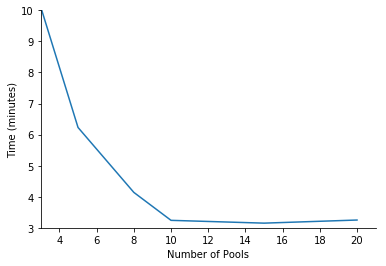

In [336]:
################################################################
####### Results of multiprocessing with different pools ########
################################################################

# first results of the first 100 listings to check multiprocessing is working 
# takes 1.789 seconds 
Abnb100 = Abnb.iloc[:100,:]

# takes 9.828 seconds
Abnb1000 = Abnb.iloc[:1000,:]

### Below are a set of results which I computed with the multiprocessing code fiddling with the number of processors

# Full data takes 0:10:10.059769 (3 pools, chunksize 1)

# Full data takes 0:06:22.602187 (5 pools, chunksize 1)

# Full data takes 0:04:13.585488 (8 pools, chunksize 1)

# Full data takes 0:03:24.388929 (10 pools, chunksize 1)

# Full data takes 0:03:15.264550 (15 pools, chunksize 1)

# Full data takes 0:03:25.767061 (20 pools, chunksize 1)

import matplotlib.pyplot as plt

Pools = [3,5,8,10,15,20]
Time = [10.10,6.23,4.14,3.24,3.15,3.25]

plt.plot(Pools,Time)
plt.xlabel('Number of Pools')
plt.ylabel('Time (minutes)')
plt.axis([3, 21, 3, 10])
plt.savefig('Pools.png')
sns.despine()
plt.show()

In [ ]:
## results stored as mprofile_Results.

## Shows that on average, each child is using 67 MiB of data and parent process uses 91 MiB 
## This totals 670+91 = 781 MiB

# Carry out analysis

In [158]:
# read in data

infile = open('MinDist','rb')
MinDist = pickle.load(infile)
infile.close()

In [159]:
# create data frame from results
df = pd.DataFrame.from_dict(MinDist,orient = 'index')

In [160]:
Abnb.sort_values(by='id').head()

,id,latitude,longitude,price
0,9554,51.587767,-0.105666,35.0
1,11076,51.515645,-0.314508,70.0
3,13913,51.568017,-0.111208,55.0
9,17402,51.520982,-0.140024,300.0
13,24328,51.472981,-0.163764,150.0


In [161]:
# Creat copy of orginal Airbnb data

Abnb2 = Abnb.copy(deep=True)

In [162]:
# Merge dataframes

MergedDf = Abnb2.merge(df,how = 'inner',right_index = True, left_on = 'id')
MergedDf.rename(columns={ df.columns[-1]: "Distance" },inplace = True)

In [169]:
MergedDf.head()

,id,latitude,longitude,price,Distance
0,9554,51.587767,-0.105666,35.0,2.445701
1,11076,51.515645,-0.314508,70.0,0.715161
2,90663,51.507800,-0.122597,231.0,0.170104
3,13913,51.568017,-0.111208,55.0,1.294063
4,90681,51.447624,-0.057157,51.0,0.826928


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


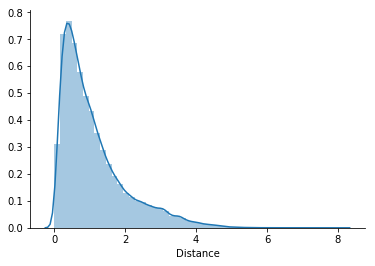

In [246]:
# Summary statistics on distance
# MergedDf.hist(column = 'Distance')
sns.distplot(MergedDf.Distance)
sns.despine()
plt.savefig('HistDist.png')

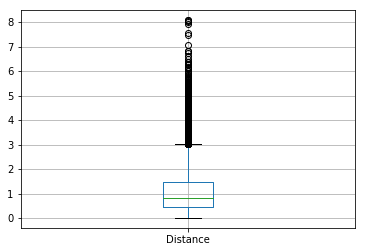

In [170]:
MergedDf.boxplot(column = 'Distance')

In [171]:
MergedDf.Distance.describe()

count    74153.000000
mean         1.099194
std          0.914138
min          0.004081
25%          0.435136
50%          0.821256
75%          1.468541
max          8.072363
Name: Distance, dtype: float64

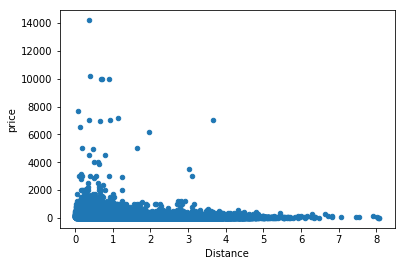

In [253]:
# Plot price and dist against each other
MergedDf.plot.scatter('Distance','price')

In [357]:
# Remove daily price outliers - some prices seem to be artifically high, maybe a data error
MergedDf_test = MergedDf[MergedDf['price']<=4000 ]

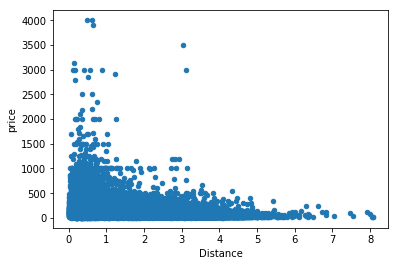

In [359]:
MergedDf_test.plot.scatter('Distance','price')

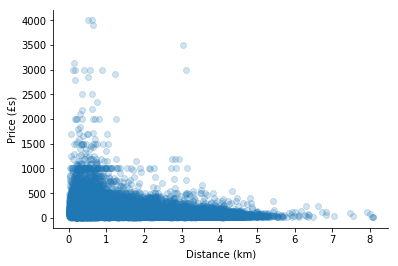

In [366]:
plt.scatter(MergedDf_test['Distance'],MergedDf_test['price'], alpha = 0.2)
plt.xlabel('Distance (km)')
plt.ylabel('Price (£s)')
# plt.axis([0, 1.05, 36, 50])
sns.despine()
plt.savefig('Scatter.png')

In [415]:
# Perform a pearsonr correlation test

from scipy.stats import pearsonr
print(pearsonr(MergedDf_test['Distance'], MergedDf_test['price']))


(-0.1809361640180145, 0.0)
